In [1]:
import sys
sys.path.append("..")


In [2]:
import torch

from data.dataloader import LowLightDataModule
from model.blocks.contourlet import ContourletTransform
from model.blocks.directionalfusion import DirectionalFusion
from model.blocks.unet import UNet
from utils.utils import show_batch


In [3]:
data_module = LowLightDataModule(
    train_dir="../data/1_train",
    valid_dir="../data/2_valid",
    bench_dir="../data/3_bench",
    infer_dir="../data/4_infer",
    image_size=640,
    batch_size=1,
    num_workers=4
)

data_module.setup()


In [4]:
train_dataloader = data_module.train_dataloader()


In [5]:
train_low, train_high = next(iter(train_dataloader))
print(train_low.shape)
print(train_high.shape)
# show_batch(images=train_low)
# show_batch(images=train_high)


torch.Size([1, 3, 640, 640])
torch.Size([1, 3, 640, 640])


In [6]:
contourlet = ContourletTransform(
    in_channels=3,
    num_levels=4,
    filter_size=5,
    sigma=1.0,
    omega_x=0.25,
    omega_y=0.25
)

directioanlfusion = DirectionalFusion(
    in_channels=3,
    hidden_channels=64,
    num_levels=4,
    squeeze_ratio=0.3
)

unet = UNet(
    in_channels=3,
    out_channels=3,
    hidden_channels=64,
    num_levels=4,
    temb_dim=64,
    dropout_ratio=0.1,
    shortcut=False,
    trainable=False
)


c:\Users\jungih\dev\ContourDiffusion\.venv\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
train_high = train_high.cuda()
train_low = train_low.cuda()
t = torch.randint(low=0, high=10000, size=(1,)).cuda()

contourlet = contourlet.cuda()
directioanlfusion = directioanlfusion.cuda()
unet = unet.cuda()

pyramid, subbands = contourlet(train_high)
fusion = directioanlfusion(subbands)
out = unet(train_high, train_low, t, fusion)


ModuleDict(
  (down1): ModuleList(
    (0): ResnetBlock(
      (gn1): GroupNorm(32, 64, eps=1e-06, affine=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): SiLU()
      (temb_proj): TimeEmbeddingBlock(
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (act): SiLU()
      )
      (gn2): GroupNorm(32, 128, eps=1e-06, affine=True)
      (act2): SiLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (nein_shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Downsample(
      (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
  )
  (down2): ModuleList(
    (0): ResnetBlock(
      (gn1): GroupNorm(32, 128, eps=1e-06, affine=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (

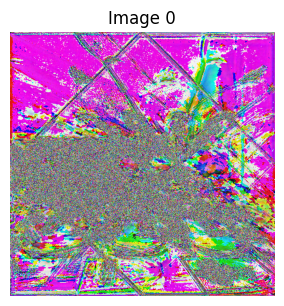

In [8]:
show_batch(images=out)
